In [186]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [155]:
def computeFairnessMetrics(model, X, Y):
    
    tn, fp, fn, tp = confusion_matrix(model.predict(X), Y).ravel()
    
    statistical_parity_ratio = (tp + fp) / (tp + fp + tn + tn)
    equal_opportunity_ratio = tp / (tp + fn)
    predictive_equality_ratio = fp / (fp + tn)
    predictive_parity_ratio = tp / (tp + fp)

    fairnessDict = {"statistical_parity_ratio" : statistical_parity_ratio, 
                    "equal_opportunity_ratio" : equal_opportunity_ratio,
                    "predictive_equality_ratio" : predictive_equality_ratio,
                    "predictive_parity_ratio" : predictive_parity_ratio}
    
    return fairnessDict

In [144]:
data = pd.read_csv("train.csv")
# get rid of passenger id, name and age
cleaned = data.drop(['PassengerId', 'Name', 'Age'], axis=1)
dummies = pd.get_dummies(cleaned)

X = dummies.drop('Survived', axis=1)
Y = dummies.Survived
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

In [145]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [146]:
print(f"Training accuracy: {gbc.score(X_train, y_train)}. Validation accuracy: {gbc.score(X_test, y_test)}")

Training accuracy: 0.8619582664526485. Validation accuracy: 0.7798507462686567


In [147]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [148]:
print(f"Training accuracy: {rf.score(X_train, y_train)}. Validation accuracy: {rf.score(X_test, y_test)}")

Training accuracy: 0.9935794542536116. Validation accuracy: 0.7910447761194029


In [149]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [150]:
print(f"Training accuracy: {knn.score(X_train, y_train)}. Validation accuracy: {knn.score(X_test, y_test)}")

Training accuracy: 0.8443017656500803. Validation accuracy: 0.7910447761194029


In [151]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [152]:
print(f"Training accuracy: {svm.score(X_train, y_train)}. Validation accuracy: {svm.score(X_test, y_test)}")

Training accuracy: 0.5682182985553772. Validation accuracy: 0.5671641791044776


In [153]:
models = [gbc, rf, knn, lr]
names = ["gradient boosting", "random forest", "KNN", "logistic regression"]

In [161]:
results = []
X_val_male = X_test[X_test['Sex_male'] == 1]
y_val_male = y_test[X_test['Sex_male'] == 1]
X_val_female = X_test[X_test['Sex_female'] == 1]
y_val_female = y_test[X_test['Sex_female'] == 1]

for i in range(len(models)):
    fairnessDictMale = computeFairnessMetrics(models[i], X_val_male, y_val_male)
    for k, v in fairnessDictMale.items():
        results.append(pd.DataFrame({'metric' : k, 'score' : v, 'sex' : 'male', 'model' : names[i]}, index=[0]))
    
    fairnessDictFemale = computeFairnessMetrics(models[i], X_val_female, y_val_female)
    for k, v in fairnessDictFemale.items():
        results.append(pd.DataFrame({'metric' : k, 'score' : v, 'sex' : 'female', 'model' : names[i]}, index=[0]))

In [163]:
combo = pd.concat(results)

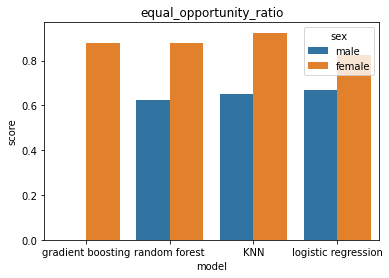

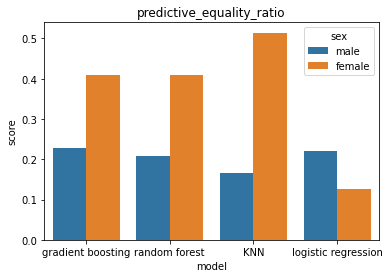

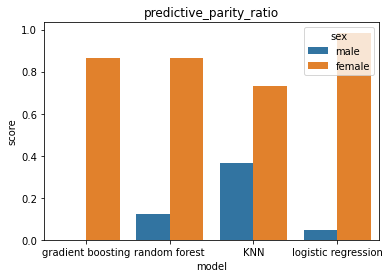

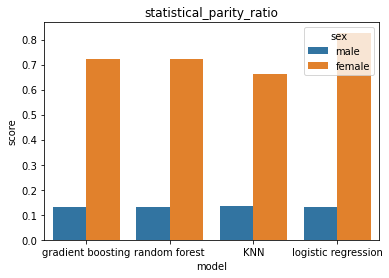

In [217]:
for metric, df in combo.groupby('metric'):
    male = df[df.sex == 'male']
    female = df[df.sex == 'female']
    
    sns.barplot(data=df[df["metric"].eq(metric)], x="model", y="score", hue="sex")
    plt.title(metric)
    plt.show()

Wnioski: <br>
- z wykresów widać, że modele dyskryminują mężczyzn
- ciekawy jest fakt, że KNN także dyskryminuje mężczyn. Ciekawy dlatego, że metryka odległości w KNN jest neutralna dla każdego atrybutu
- trudno jest wyróżnić model, który jest najbardziej "fair"